# 1. Data Loading, Preprocessing, and Cleaning
**Andrew Dang**  

**BrainStation, Data Science**  

**Next Notebook: 2. EDA and Feature Engineering**

What do people talk about when they talk about whisky? 

In this project, I want to gain a better understanding of the language used to describe whiskys. In particular, I am interested in investigating the following topics: 
1. Determine which words used by reviewers influence ratings positively. Distillers can use this information to write marketing material to convince customers to purchase their products. 
2. See how words describing different flavours positively or negatively influence the whisky ratings. Knowing which flavours positively and negatively affect the rating inform distillers which flavours they should try to include or avoid having in their products. 

This project will be using whiskey reviews written by a panel of experts and try to predict their rating assigned to them. From there, we can look at how each individual word affects the whiskys' ratings. The data used for this project was acquired by scraping the [Whisky Advocate](https://www.whiskyadvocate.com/) website. The Whisky Advocate is America's leading spirits magazine, and each review is written by a whisky expert. The scraped data was uploaded by a kaggle user and can be found [here](https://www.kaggle.com/koki25ando/22000-scotch-whisky-reviews). The data consists of the name of the whisky under review, the rating it recieved, as well as information regarding the category of the whisky, and price. 

The goal of this notebook is to clean our data and preprocess our text for modeling. 

Let's read in the data. 

First, we will need to import our packages.


In [1]:
# import standard data science packages
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np 

# import preprocessing packages
from sklearn.preprocessing import OneHotEncoder

# text cleaning tools
import re 
import string

import pickle
import joblib

In [2]:
# reading in the data
data = pd.read_csv('data/scotch_review.csv')

# inspect the data
data.head()

,Unnamed: 0,name,category,review.point,price,currency,description
0,1,"Johnnie Walker Blue Label, 40%",Blended Scotch Whisky,97,225,$,"Magnificently powerful and intense. Caramels, ..."
1,2,"Black Bowmore, 1964 vintage, 42 year old, 40.5%",Single Malt Scotch,97,4500.00,$,What impresses me most is how this whisky evol...
2,3,"Bowmore 46 year old (distilled 1964), 42.9%",Single Malt Scotch,97,13500.00,$,There have been some legendary Bowmores from t...
3,4,"Compass Box The General, 53.4%",Blended Malt Scotch Whisky,96,325,$,With a name inspired by a 1926 Buster Keaton m...
4,5,"Chivas Regal Ultis, 40%",Blended Malt Scotch Whisky,96,160,$,"Captivating, enticing, and wonderfully charmin..."


## Checking data types 
The next step is to inspect each column in our dataset. 

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2247 entries, 0 to 2246
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    2247 non-null   int64 
 1   name          2247 non-null   object
 2   category      2247 non-null   object
 3   review.point  2247 non-null   int64 
 4   price         2247 non-null   object
 5   currency      2247 non-null   object
 6   description   2247 non-null   object
dtypes: int64(2), object(5)
memory usage: 123.0+ KB


## Inspecting the data
- `Unnamed: 0`: This appears to be an index value to represent the ID of the review. We can take a look at the length of the - unique values and see if it matches with the number of rows. If so, then we can drop this column.  
- `name`: This column is a string. It contains the name of the whisky, and the alcohol content of the whisky as well. The age of the whisky occasionally appears here. The age is something we might be able to extract from this column and use as a feature.   
- `category`: This classifies the whisky into different types of whiskys suchas a single versus a blended malt.   
- `review.point`: This is a numeric column. This is the rating of the whisky.   
- `price`: The price of the whisky. Oddly enough, this is a string. To use this as a feature in our model, we will need to convert this to a numeric data type.   
- `currency`: Another string. This appears to denote what type of currency the price is in (USD vs. EUR). Perhaps we need to convert the prices so they are all the same currency for a fair comparison.   
- `description`: This is the review of the whisky.   

We can perform further inspection of `Unnamed: 0` to see if it can be dropped, and whether or not there is more than one currency. If so, we need to convert. As this column only contains a symbol, we can drop this once we confirm the prices are all using the same currency. 

In [4]:
# Does the Unnamed: 0 column have the same length as the number of rows?
len(data['Unnamed: 0'].unique()) == data.shape[0]

True

In [5]:
# Checking currency to see the different currencies used in the dataset
data['currency'].value_counts()

$    2247
Name: currency, dtype: int64

## Dropping columns
`Unnamed: 0` does appear to be the same length as the number of rows, indicating that this is just an index. It is safe to drop this column. There also appears to be only one type of currency in our dataset. We can safely drop `currency`, and we do not require to convert any of the prices. 

In [6]:
# Dropping columns
data.drop(['Unnamed: 0', 'currency'], axis=1, inplace=True)

# Inspect the data
data.head()

,name,category,review.point,price,description
0,"Johnnie Walker Blue Label, 40%",Blended Scotch Whisky,97,225,"Magnificently powerful and intense. Caramels, ..."
1,"Black Bowmore, 1964 vintage, 42 year old, 40.5%",Single Malt Scotch,97,4500.00,What impresses me most is how this whisky evol...
2,"Bowmore 46 year old (distilled 1964), 42.9%",Single Malt Scotch,97,13500.00,There have been some legendary Bowmores from t...
3,"Compass Box The General, 53.4%",Blended Malt Scotch Whisky,96,325,With a name inspired by a 1926 Buster Keaton m...
4,"Chivas Regal Ultis, 40%",Blended Malt Scotch Whisky,96,160,"Captivating, enticing, and wonderfully charmin..."


## Missing and duplicated data
Next, we will inspect our data for missing and duplicated data.

In [7]:
# Check for missing data
data.isna().sum()

name            0
category        0
review.point    0
price           0
description     0
dtype: int64

In [8]:
# Check for duplicated data
data.duplicated().sum()

2

In [9]:
# Inspect duplicated rows 
data[data.duplicated(keep=False)]

,name,category,review.point,price,description
537,"Chapter 7 (undisclosed Highland distillery), 5...",Single Malt Scotch,90,180,Swiss-based Chapter 7 released this 19 year ol...
570,"Chapter 7 (undisclosed Highland distillery), 5...",Single Malt Scotch,90,180,Swiss-based Chapter 7 released this 19 year ol...
2116,"Ledaig, 10 year old, 43%",Single Malt Scotch,80,48.00,"Sweet, ripe barley, balanced by damp peat, tar..."
2125,"Ledaig, 10 year old, 43%",Single Malt Scotch,80,48.00,"Sweet, ripe barley, balanced by damp peat, tar..."


We do not have any missing rows. When we checked for duplicated rows, we found that we had 2 duplicated rows. We will drop those now. 

In [10]:
# Dropping duplicated rows
data.drop_duplicates(inplace=True, ignore_index=True)

# Check shape of data. There should be two less rows, so there should be 2245 rows. 
print(data.shape)

# Inspect data again
data.head()

(2245, 5)


,name,category,review.point,price,description
0,"Johnnie Walker Blue Label, 40%",Blended Scotch Whisky,97,225,"Magnificently powerful and intense. Caramels, ..."
1,"Black Bowmore, 1964 vintage, 42 year old, 40.5%",Single Malt Scotch,97,4500.00,What impresses me most is how this whisky evol...
2,"Bowmore 46 year old (distilled 1964), 42.9%",Single Malt Scotch,97,13500.00,There have been some legendary Bowmores from t...
3,"Compass Box The General, 53.4%",Blended Malt Scotch Whisky,96,325,With a name inspired by a 1926 Buster Keaton m...
4,"Chivas Regal Ultis, 40%",Blended Malt Scotch Whisky,96,160,"Captivating, enticing, and wonderfully charmin..."


In [11]:
data.shape

(2245, 5)

***

## Looking at categories
Next, we will at the categories. I am interested to see if there is any difference in the ratings based on the categories of the whisky. We will use boxplots and plot their distributions to investigate this.


In [12]:
# Number of whiskys per category 
data['category'].value_counts()

Single Malt Scotch            1817
Blended Scotch Whisky          211
Blended Malt Scotch Whisky     132
Single Grain Whisky             57
Grain Scotch Whisky             28
Name: category, dtype: int64

C:\Users\andre\anaconda3\envs\capstone\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\andre\anaconda3\envs\capstone\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\andre\anaconda3\envs\capstone\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level f

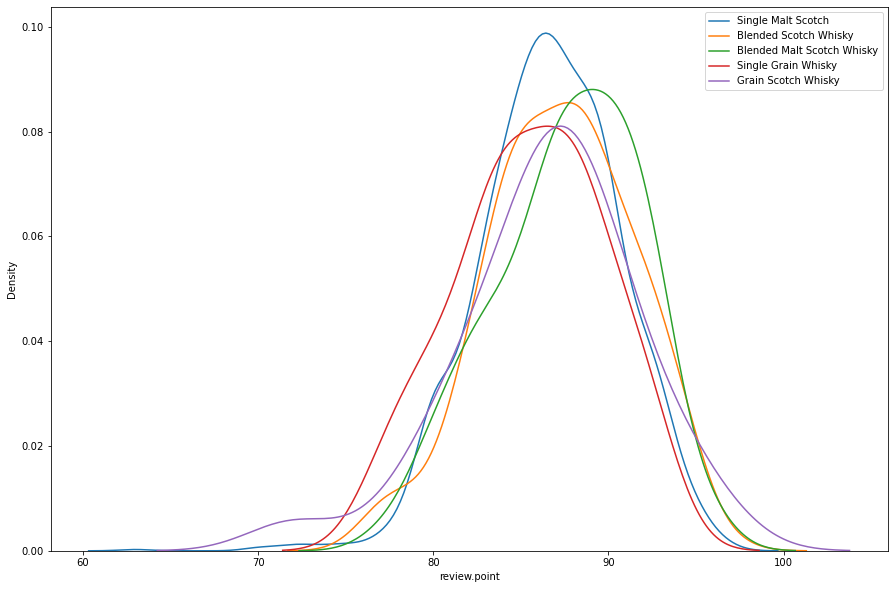

In [13]:
# plotting distributions on the same graph

import seaborn as sns
sms = data[data['category'] == 'Single Malt Scotch']
bsw = data[data['category'] == 'Blended Scotch Whisky']
bmsw = data[data['category'] == 'Blended Malt Scotch Whisky']
sgw = data[data['category'] == 'Single Grain Whisky']
gsw = data[data['category'] == 'Grain Scotch Whisky']
 
plt.figure(figsize=(15,10))
sns.distplot(sms['review.point'], hist=False, label='Single Malt Scotch')
sns.distplot(bsw['review.point'], hist=False, label='Blended Scotch Whisky')
sns.distplot(bmsw['review.point'], hist=False, label='Blended Malt Scotch Whisky')
sns.distplot(sgw['review.point'], hist=False, label='Single Grain Whisky')
sns.distplot(gsw['review.point'], hist=False, label='Grain Scotch Whisky')
# sns.distplot(data['review.point'], hist=False, label='All Whisky')
plt.legend()
plt.show()

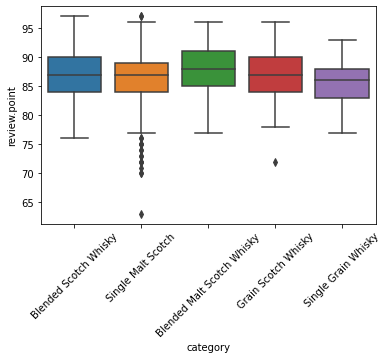

In [14]:
# Plotting boxplots for each category
plt.figure()
sns.boxplot(x=data['category'], y=data['review.point'])
plt.xticks(rotation=45)
plt.show()

While there does appear to be a large amount of overlap distributions for the different categories, the shape of the distribution functions vary slightly from category to category. In particular, the Single Grain Whisky has a longer tail than others, Blended Malt Scotch Whiskys have their distibution function shifted slightly to the right, and the Single Malt Scotches have a sligtly narrower distribution function. With this in mind, we will one-hot encode categories, and drop the original `category` column. 

In [15]:
# Instantiate encoder
ohe = OneHotEncoder()

# Column needs to be a 1D array 
category_array = np.array(data['category']).reshape(-1,1) 

# Fit the encoder
ohe.fit(category_array)

# One-hot encode the column, and put the transformed data into a dataframe 
ohe_category = ohe.transform(category_array).toarray()

# Feature names from encoder adds a prefix and looks messy. Hard code the column names instead
columns = ['Blended Malt Scotch Whisky', 'Blended Scotch Whisky', 'Grain Scotch Whisky', 'Single Grain Whisky', 'Single Malt Scotch']
ohe_df = pd.DataFrame(data=ohe_category, columns=columns)

# Add these columns to data, and drop original category column
data = pd.concat([data, ohe_df], axis=1)
data.drop('category', axis=1, inplace=True)

# Inspect data 
data.head()


,name,review.point,price,description,Blended Malt Scotch Whisky,Blended Scotch Whisky,Grain Scotch Whisky,Single Grain Whisky,Single Malt Scotch
0,"Johnnie Walker Blue Label, 40%",97,225,"Magnificently powerful and intense. Caramels, ...",0.0,1.0,0.0,0.0,0.0
1,"Black Bowmore, 1964 vintage, 42 year old, 40.5%",97,4500.00,What impresses me most is how this whisky evol...,0.0,0.0,0.0,0.0,1.0
2,"Bowmore 46 year old (distilled 1964), 42.9%",97,13500.00,There have been some legendary Bowmores from t...,0.0,0.0,0.0,0.0,1.0
3,"Compass Box The General, 53.4%",96,325,With a name inspired by a 1926 Buster Keaton m...,1.0,0.0,0.0,0.0,0.0
4,"Chivas Regal Ultis, 40%",96,160,"Captivating, enticing, and wonderfully charmin...",1.0,0.0,0.0,0.0,0.0


***

## Cleaning Price
Now that we have dropped some columns, we need to tackle cleaning `price`, and then move on to `description`. 
Let's first look at the unique values in this column

In [16]:
# Look at the unique values
data['price'].unique()

array(['225', '4500.00', '13500.00', '325', '160', '85.00', '6250.00',
       '11000.00', '1500.00', '3360', '750.00', '3108', '105.00', '120',
       '3500.00', '70.00', '20000.00', '$15,000 or $60,000/set', '26650',
       '400.00', '200.00', '455.00', '750', '460.00', '2525.00',
       '1250.00', '280.00', '500.00', '215.00', '300.00', '2000.00',
       '4000', '225.00', '60.00', '180', '3500', '181.00', '800.00',
       '250.00', '6000.00', '30,000', '645.00', '11824', '1250', '550.00',
       '700.00', '140.00', '387', '5730.00', '100', '325.00', '350.00',
       '6088.00', '112.00', '109.00', '130', '100.00', '120.00',
       '1900.00', '1400', '84.00', '3000', '164', '50.00', '150', '140',
       '175', '1100', '157000.00', '850', '34.00', '600.00', '55.00',
       '60', '60,000/set', '90.00', '191.00', '1925', '2200', '1,700',
       '430.00', '1,100', '150.00', '135', '3000.00', '60,000', '95.00',
       '262', '599.00', '9420.00', '45', '2850.00', '1000.00', '3657.00',
      

Looking at the list above, there are some strange values. Some prices seem like they are part of a set. Let's look at those rows. 

In [17]:
# Empty list to store index of rows that match our condition
indices = []

# Look for rows that have 60,000/set in the string
for i, price_string in enumerate(data['price']):
    words = price_string.split(' ')
    if '60,000/set' in words:
        indices.append(i)
    if '$60,000/set' in words:
        indices.append(i)

# Look at rows that have values in 'price' column that match the above conditions
data.iloc[indices]

,name,review.point,price,description,Blended Malt Scotch Whisky,Blended Scotch Whisky,Grain Scotch Whisky,Single Grain Whisky,Single Malt Scotch
19,"Balvenie 1973 43 year old, 46.6%",95,"$15,000 or $60,000/set",This expression was matured in a European oak ...,0.0,0.0,0.0,0.0,1.0
95,"Balvenie 1961 55 year old, 41.7%",93,"60,000/set",Aged in a European oak oloroso sherry hogshead...,0.0,0.0,0.0,0.0,1.0
410,"Balvenie 1981 35 year old, 43.8%",90,"60,000/set",A refill American oak hogshead matured this wh...,0.0,0.0,0.0,0.0,1.0
999,"Balvenie 1993 23 year old, 51.9%",87,"60,000/set",This was aged in a refill American oak hogshea...,0.0,0.0,0.0,0.0,1.0
1214,"Balvenie 2004 13 year old, 58.2%",86,"60,000/set",This expression was aged in a European oak olo...,0.0,0.0,0.0,0.0,1.0


It looks like these rows are part of the same set, as they are from the same distiller, Balvenie. I think it makes sense to change the price to $15,000 for these rows. 

In [18]:
data['price'].iloc[indices] = '15000'
data.iloc[indices]

C:\Users\andre\anaconda3\envs\capstone\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,name,review.point,price,description,Blended Malt Scotch Whisky,Blended Scotch Whisky,Grain Scotch Whisky,Single Grain Whisky,Single Malt Scotch
19,"Balvenie 1973 43 year old, 46.6%",95,15000,This expression was matured in a European oak ...,0.0,0.0,0.0,0.0,1.0
95,"Balvenie 1961 55 year old, 41.7%",93,15000,Aged in a European oak oloroso sherry hogshead...,0.0,0.0,0.0,0.0,1.0
410,"Balvenie 1981 35 year old, 43.8%",90,15000,A refill American oak hogshead matured this wh...,0.0,0.0,0.0,0.0,1.0
999,"Balvenie 1993 23 year old, 51.9%",87,15000,This was aged in a refill American oak hogshea...,0.0,0.0,0.0,0.0,1.0
1214,"Balvenie 2004 13 year old, 58.2%",86,15000,This expression was aged in a European oak olo...,0.0,0.0,0.0,0.0,1.0


### Continue cleaning price
- **Remove commas**: As price is being represented as a string, some of the prices look like they have commas to make larger values more readable. We eventually want to convert this value into a numeric value, so we will need to remove these commas. 
- **Split string**: Some values have strings with more than one "word". However, the first word seems to always be the price. If we split the string using a space as our separator, and only keep the first index, we should be able to get just the numeric value back. 
- **Remove '/words'**: This is a special case. Some values have their price noted as price per some amount, denoted by the forward slash (ex. 44/liter). We should be able to use regular expressions to split the string into everything before and after the forward slash and just keep the numeric value. 
- **Remove currency symbols**: Currency symbols will cause problems for us if we try to convert this to a float. Remove these too.

In [19]:
# Cleaning price
# function to strip the price string of alphabetical chracters
import re

def clean_text_price(text):
    '''Remove commas, forward slashes, currency symbols, and split the string to clean the data.'''
    text = text.split(' ')[0]
    text = re.sub(r'\/\w+', '', text)
    text = re.sub('[%s]' % re.escape(','), '', text)
    text = re.sub('[%s]' % re.escape('$'), '', text)
    return text

# create lambda function to apply to our dataframe
clean_price_string = lambda x: clean_text_price(x)

In [20]:
# Apply lambda function to clean price and add column to data 
price_clean = data['price'].apply(clean_price_string)
data['price_string'] = price_clean
data['price_string'] = pd.to_numeric(data['price_string'], downcast='float')

data.drop('price', axis=1, inplace=True)
data.head()

,name,review.point,description,Blended Malt Scotch Whisky,Blended Scotch Whisky,Grain Scotch Whisky,Single Grain Whisky,Single Malt Scotch,price_string
0,"Johnnie Walker Blue Label, 40%",97,"Magnificently powerful and intense. Caramels, ...",0.0,1.0,0.0,0.0,0.0,225.0
1,"Black Bowmore, 1964 vintage, 42 year old, 40.5%",97,What impresses me most is how this whisky evol...,0.0,0.0,0.0,0.0,1.0,4500.0
2,"Bowmore 46 year old (distilled 1964), 42.9%",97,There have been some legendary Bowmores from t...,0.0,0.0,0.0,0.0,1.0,13500.0
3,"Compass Box The General, 53.4%",96,With a name inspired by a 1926 Buster Keaton m...,1.0,0.0,0.0,0.0,0.0,325.0
4,"Chivas Regal Ultis, 40%",96,"Captivating, enticing, and wonderfully charmin...",1.0,0.0,0.0,0.0,0.0,160.0


***

## Cleaning `description`
The next step is to clean or preprocess the reviews before it gets vectorized. First, let's investigate what some reviews look like. 

In [21]:
# Let's look at the first 10 reviews. 
review_list = []

for review in data['description'].head(20):
    review_list.append(review)
    
# Inspect the first 10 reviews. 
review_list

["Magnificently powerful and intense. Caramels, dried peats, elegant cigar smoke, seeds scraped from vanilla beans, brand new pencils, peppercorn, coriander seeds, and star anise make for a deeply satisfying nosing experience. Silky caramels, bountiful fruits of ripe peach, stewed apple, orange pith, and pervasive smoke with elements of burnt tobacco. An abiding finish of smoke, dry spices, and banoffee pie sweetness. Close to perfection. Editor's Choice",
 "What impresses me most is how this whisky evolves; it's incredibly complex. On the nose and palate, this is a thick, viscous, whisky with notes of sticky toffee, earthy oak, fig cake, roasted nuts, fallen fruit, pancake batter, black cherry, ripe peach, dark chocolate-covered espresso bean, polished leather, tobacco, a hint of wild game, and lingering, leafy damp kiln smoke. Flavors continue on the palate long after swallowing. This is what we all hope for (and dream of) in an older whisky!",
 "There have been some legendary Bowmor

## Initial thoughts for cleaning text
- There are string literals (eg. \n, \r, \t) that can be removed. These shouldn't have any meaning to the review, and we should remove them,
- '\xa0' shows up in the reviews occasionally. This is apparently a non-breaking space. We will replace this with a space. 
- The typical text cleaning process will also be completed - remove punctuation, and lowercase all the text

Once the cleaning is complete, we can drop the `desription` column

In [22]:
# Clean text first
def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation, and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text) # remove square brackets
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('[‘’“”…]', '', text) # more punctuation removal
    return text

round1 = lambda x: clean_text_round1(x)

def clean_text_round2(text):
    '''Get rid of string literals that was missed the first time around.'''
    text = re.sub('\t','', text)
    text = re.sub('\n', '', text)
    text = re.sub('\r', '', text)
    text = re.sub('\xa0',' ', text)
    return text

round2 = lambda x: clean_text_round2(x)

In [23]:
# Apply the cleaning functions to the reviews
data['cleaned_reviews'] = data['description'].apply(round1)
data['cleaned_reviews'] = data['cleaned_reviews'].apply(round2)

## Inspect cleaned reviews

In [24]:
# Let's look at the first 20 reviews. 
clean_review_list = []

for review in data['cleaned_reviews'].head(20):
    clean_review_list.append(review)
    
# Inspect the first 10 reviews. 
clean_review_list

['magnificently powerful and intense caramels dried peats elegant cigar smoke seeds scraped from vanilla beans brand new pencils peppercorn coriander seeds and star anise make for a deeply satisfying nosing experience silky caramels bountiful fruits of ripe peach stewed apple orange pith and pervasive smoke with elements of burnt tobacco an abiding finish of smoke dry spices and banoffee pie sweetness close to perfection editors choice',
 'what impresses me most is how this whisky evolves its incredibly complex on the nose and palate this is a thick viscous whisky with notes of sticky toffee earthy oak fig cake roasted nuts fallen fruit pancake batter black cherry ripe peach dark chocolatecovered espresso bean polished leather tobacco a hint of wild game and lingering leafy damp kiln smoke flavors continue on the palate long after swallowing this is what we all hope for and dream of in an older whisky',
 'there have been some legendary bowmores from the mid60s and this is every bit the

We're only looking at the first 20 reviews, but it looks promising so far. Once we vectorize our text, if we still see some nonsense words, we can come back and clean the data again. For now, we can drop the `description` column.

In [25]:
# Drop description
data.drop('description', axis=1, inplace=True)

# Inspect the data
data.head()

,name,review.point,Blended Malt Scotch Whisky,Blended Scotch Whisky,Grain Scotch Whisky,Single Grain Whisky,Single Malt Scotch,price_string,cleaned_reviews
0,"Johnnie Walker Blue Label, 40%",97,0.0,1.0,0.0,0.0,0.0,225.0,magnificently powerful and intense caramels dr...
1,"Black Bowmore, 1964 vintage, 42 year old, 40.5%",97,0.0,0.0,0.0,0.0,1.0,4500.0,what impresses me most is how this whisky evol...
2,"Bowmore 46 year old (distilled 1964), 42.9%",97,0.0,0.0,0.0,0.0,1.0,13500.0,there have been some legendary bowmores from t...
3,"Compass Box The General, 53.4%",96,1.0,0.0,0.0,0.0,0.0,325.0,with a name inspired by a 1926 buster keaton m...
4,"Chivas Regal Ultis, 40%",96,1.0,0.0,0.0,0.0,0.0,160.0,captivating enticing and wonderfully charming ...


***

## Extract age from name
The age of the whiskey appears to be in `name` column. I am interested to see how many ages we can find, and see if we can use age as an additional feature. We can use regular expressions to find whiskys that contain "year old" in the name. 

In [26]:
# create function to extract age frim the name column
def find_age(text):
    m = re.search('\d{1,2} year', text)
    if m:
        found = m.group(0)
    else: 
        found = np.nan
    
    return found

# create lambda function to apply to entire dataset
whiskey_age = lambda x: find_age(x)
ages = pd.DataFrame(data['name'].apply(whiskey_age))

In [27]:
# How many rows am I missing ages for?
ages['name'].isna().sum()

1032

It appears that I have over 1,000 of 2,245 rows that are missing information regarding the age of the whisky. Occasionally the year that the whisky began the maturation process is in the name, but we do not have any information regarding when the review was written. This means we cannot simply subtract the year in the name with the current year to get the age of the whisky. Given enough time, it is not impossible to Google the age for whiskys we are missing that information for. However, as of now, it is impractical. We will not pursue using age as a feature for the moment. 

We will keep the name column as is so that we can refer to the name of the whisky during our analysis.

***

# Conclusion
We have checked the data for missing and duplicated data and dealt with them accordingly. We one-hot encoded the `category` column. We have also cleaned the `price` column, and converted it into a numeric data type (float). Then, we preprocessed our reviews. We attempted to extract the age of the whiskies from the `name`, but found that we had too many missing values. 

We will now save the DataFrame we were working with as a pickle file to use in future notebooks. 

In the next notebook, **2. EDA**, we will explore the relationship between our input features, and our target variable, `review.point`.

In [28]:
# Save data as pickle file
joblib.dump(data, 'data/cleaned_data.pkl')

['data/cleaned_data.pkl']